Starting by importing pandas, plt and the file with stock data

                    Unnamed: 0        Open        High         Low  \
100  2022-04-25 10:22:00-04:00  136.250000  136.304993  136.110001   
101  2022-04-25 10:24:00-04:00  136.289993  136.679993  136.250000   
102  2022-04-25 10:26:00-04:00  136.580002  136.605392  136.354996   
103  2022-04-25 10:28:00-04:00  136.380005  136.419998  136.050003   
104  2022-04-25 10:30:00-04:00  136.119995  136.205002  135.960007   
105  2022-04-25 10:32:00-04:00  136.250000  136.539993  136.250000   
106  2022-04-25 10:34:00-04:00  136.600006  136.860001  136.570007   
107  2022-04-25 10:36:00-04:00  136.610001  136.679993  136.470001   
108  2022-04-25 10:38:00-04:00  136.490005  136.490005  136.039993   
109  2022-04-25 10:40:00-04:00  136.050003  136.070007  135.880005   

          Close   Adj Close   Volume       STD  
100  136.280701  136.280701  15921.0  0.009331  
101  136.589996  136.589996  39883.0  0.009312  
102  136.410004  136.410004  21548.0  0.009283  
103  136.145004  136.145004  2222

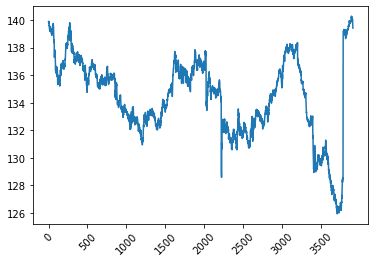

In [249]:
import matplotlib.pyplot as plt
import pandas as pd
file = "IBM2min.csv"
df = pd.read_csv(file)
#df.set_index(df.Datetime, inplace=True)
close = df.Close.values
df["STD"] = df.Close.rolling(50).std()/df.Close.rolling(5).mean()
print(df[100:110])
plt.xticks(np.arange(0, len(df)+1, 500), rotation=45)
plt.plot(df.index, df.Close)
#plt.plot(df.STD)

Creating labels using CTL from my julialang package "FinanceTools", the function result begins and ends with "0" which i'll set to -1 since they aren't a defined class for the model. The "omega" is paramater for the labelling function, adjusting omega changes the sensitivity to trend changes.

Function for labels as written in Julia:
```
function trendlabel(x::AbstractArray, ω::Real)
    N = length(x) # paper uses N as length of vector
    t = collect(1:N) # paper uses this thing for some reason
    y = zeros(Int8, N) # initialise array containing labels
    #initialising stuff
    FP = x[1] # first price
    xₕ = x[1] # highest price as of yet
    xₗ = x[1] #lowest price as of yet
    HT = t[1] #time highest price was reached
    LT = t[1] #time the lowest price was reached
    Cid = 0 #direction of trend
    FP_N = 0 # index of first price for loop
    #alg starts here
    for i in 1:N
        if x[i] > FP + x[1] * ω
            xₕ, HT, FP_N, Cid = x[i], t[i], i, 1
            break
        end
        if x[i] < FP - x[1] * ω
            xₗ, LT, FP_N, Cid = x[i], t[i], i, -1
            break
        end
    end

    for i in FP_N+1:N
        # Trending down
        if Cid > 0
            if x[i] > xₕ
                xₕ, HT = x[i], t[i]
            end
            if x[i] < xₕ - xₕ * ω && LT ≤ HT
                for j in 1:N
                    if t[j] > LT && t[j] ≤ HT
                        y[j] = 1
                    end
                end
                xₗ, LT, Cid = x[i], t[i], -1
            end
        end
        # Trending up
        if Cid < 0
            if x[i] < xₗ
                xₗ, LT = x[i], t[i]
            end
            if x[i] > xₗ + xₗ * ω && HT ≤ LT
                for j in 1:N
                    if t[j] > HT && t[j] ≤ LT
                        y[j] = -1
                    end
                end
                xₕ, HT, Cid = x[i], t[i], 1
            end
        end
    end
    return (y)
end
```

[-1 -1 -1 ... -1 -1 -1]


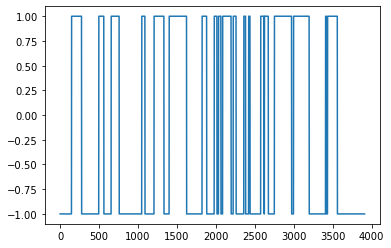

In [250]:
from julia import FinanceTools

omega = 0.01 # number can be adjusted but seems to work decently well on a large spectrum of stocks at about 0.1
labels = FinanceTools.trendlabel(close, omega)
labels[labels == 0] = -1 # replace all 0s with -1
print(labels)
plt.plot(labels)

Then I'll generate the features, in this example the model is incredibly simple and the only feature it has is the "close" series. The series will be split up in windows of [[0:tslen], [1:tslen+1]...], the last few windows are NaN and are kept to preserve the shape of the array.

In [251]:
import numpy as np
tslen = 20
timesamples = np.empty(shape=(len(close), tslen)) * np.nan
for i in range(len(close) - tslen):
    timesamples[i] = close[i : i + tslen]
print(timesamples)

[[139.88000488 139.88000488 139.86000061 ... 139.22999573 139.19500732
  139.25      ]
 [139.88000488 139.86000061 139.89950562 ... 139.19500732 139.25
  139.18499756]
 [139.86000061 139.89950562 139.82000732 ... 139.25       139.18499756
  139.27000427]
 ...
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]]


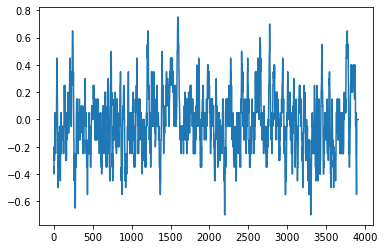

In [252]:
# cumulative up/down
updownsamples = np.zeros((len(timesamples), 1))
for i, sample in enumerate(timesamples):
    lastj = sample[0]
    change = 0
    for j in sample:
        if j > lastj:
            change += 1
        elif j < lastj:
            change -= 1
        lastj = j
    updownsamples[i] = change / tslen

plt.plot(updownsamples)


Merging all of the generated features

In [253]:
samples = np.concatenate((updownsamples, np.array(df.STD)[np.newaxis].T, timesamples), axis=1)
#feature names to be used later
feature_names = ["updown", "std"]+["ts"]*tslen

Preprocessing the timeseries, the function "scaleunclean" normalises each window to itself and skips for the last few NaN columns

In [254]:
from sklearn.preprocessing import scale

# process the samples
print(len(labels), len(samples))
nanmask = np.isnan(samples).any(axis=1)
samples = samples[~nanmask, :]
labels = labels[~nanmask]
samples = np.apply_along_axis(scale, 1, samples)
# remove  nans
# samples = samples[0:-tslen]
# samples = [[(x[-1]-x[0])/x[0]]+x for x in samples] #adding a pct change
# labels = labels[0:-tslen]
print(f"Do the samples contain any NaNs? {np.any(np.isnan(samples))}")


3911 3911
Do the samples contain any NaNs? False


Splitting datasets into training and testing sets. "split" is the fraction of data that will be used for testing. Training data is shuffled and balanced so there is an equal amount of buy and sell samples.

In [255]:
from sklearn.utils import shuffle

split = 0.6  # when to split training from testing

X_train, X_test = np.split(samples, [int(split * len(labels))])

y_train, y_test = np.split(labels, [int(split * len(labels))])

X_train, y_train = shuffle(X_train, y_train)
balance = sum(y_train)
i = 0
mask = []
while balance > 0:
    if y_train[i] == 1:
        mask.append(i)
        balance -= 1
    i += 1
X_train, y_train = np.delete(X_train, mask, axis=0), np.delete(y_train, mask, axis=0)
balance = sum(y_train)
print(f"balance of buys and sells, should be close to zero: {balance}")


balance of buys and sells, should be close to zero: -425


Creating SVM model, commented code was used to find parameters.

In [276]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#model = RandomForestClassifier(n_estimators=400) #Support vector machine gave better  results
model = SVC(max_iter=-1, cache_size=500, C=1e5, gamma = "scale", kernel="poly")
params = {
        "C":[1e1, 1e2, 1e3, 1e4],
        "kernel":("linear", "rbf", "poly", "sigmoid")
        }
''' Enable this section to find the best paramters for the support vector machine,
it has been disabled due to the long processing time
clf = GridSearchCV(model, params, n_jobs=10)
clf.fit(X_train, y_train)
print(f"Best params are: {clf.best_params_}")
'''
model.fit(X_train, y_train)

guessed_labels = model.predict(X_test)

Confusion matrix is made from the guessed labels and compared to the true labels to confirm that the model has any noticable predictive power.


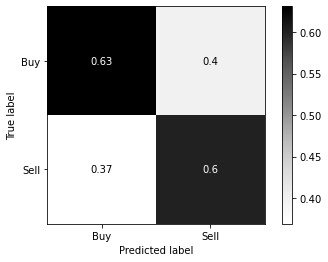

In [277]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, guessed_labels, labels=[1, -1], normalize="pred")
ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Buy", "Sell"]
).plot(cmap="Greys")



              precision    recall  f1-score   support

         Buy      0.631     0.415     0.501       905
        Sell      0.601     0.783     0.680      1016

    accuracy                          0.610      1921
   macro avg      0.616     0.599     0.591      1921
weighted avg      0.615     0.610     0.596      1921



<AxesSubplot:>

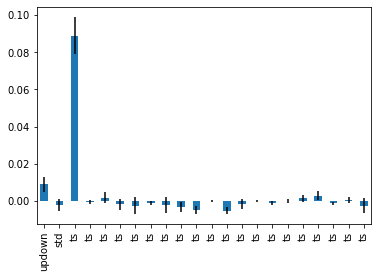

In [278]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
print(classification_report(y_test, guessed_labels, digits=3, labels=[1, -1], target_names=["Buy","Sell"])) 

result = permutation_importance(model, X_test, y_test, n_repeats=10, n_jobs=-1)
#plot importances of features
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances.plot.bar(yerr=result.importances_std)

In [279]:
#no longer needed, does the same as classification report.
'''TP, FP, FN, TN = cm.flatten()
print(f"recall: {TP/(TP+FN)}")
TPR = TP / (TP+FN)
TNR = TN/(TN+FP)
print(f"adjusted precision: {(TPR+TNR)/2}")
'''

'TP, FP, FN, TN = cm.flatten()\nprint(f"recall: {TP/(TP+FN)}")\nTPR = TP / (TP+FN)\nTNR = TN/(TN+FP)\nprint(f"adjusted precision: {(TPR+TNR)/2}")\n'

In [280]:
pd.DataFrame(dict(label=labels)).to_csv("SPYlabels.csv")
